In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

#Aquatic Climate Variation: Modeling Lake Level Temperatures


# Introduction
**Motivation and Main Theme**
The Eddy Diffusion model simulates the seasonal variation in lake temperature. This model sucessfully simulates thermal stratification in a variety of limnologic studies and has predicted both surface temperature and seasonal storage of heat. We specifically attempt to replicate the simulation in Bartlein and Hostetler's paper 'Simulation of Lake Evaporation with Application to Modeling Lake Level Variations of Harney-Malheur Lake, Oregon.

**Importance**

Utilizing the Eddy Diffusion Model aids us in,


*   Understanding limnological seasonal variations
*   Illustrate how numerical methods affect evaporation, temperature, and heat storage

This project applies the Eddy Diffusion Model to evaluate numerical techniques while examing how climate-divers varaitions influence lake temperature profiles and thermal dynamics.

**Methods Used: Crank-Nicholson and Finite Difference Method**

*    Solve the tridiagonal matrix system each step to compute updated temperature profiles
*    Incoorporated the surface heat-flux balance as a Nuemann upper boundary and enforced an insulated bottom boundary.
*    Utilized the Finite Difference method to discretize the 1D lake heat equation and represent vertical diffusion and heat-flux terms on a uniform grid.
**Relation to Other Models**

Coupled lake climate models solve mulit-layer energy budgets with wind-wave mixing, radiative transfers, and turbulence closure schems. One-dimenisonal hydrodynamic models such as a General Lake Model and Dynamic Reservior Simulations tend to add thing like variable layer thickness and full-surface atmosphere coupling. Our eddy-diffusion, Crank Nicholson model is more idealized cotaining a fixed vertical grid, simiplifed heat-flux parametrerizations, and diffusion based on mixing withoufh the full hydrodynamic momentum equations. The simplification focuses on vertical heat transport and numerical behavior, providing a clear, controlled framework for studying thermal strucutre and climate drive variability (Hostetler et al., 1990).

#Equations
**Governing Equation**

The eddy diffusion model displays the transport and mixing of heat, nutrients, oxygen, and other substances within a lake due to turbulent circulation parsels of water called eddies. This process is more effective and faster than molecular diffusion facilitating vertical and horizontal transport. Understanding eddy diffusion is critical water stratification, predicting dispersion of pollutants, and the overall health of lake ecosystems.


To form a one-dimensional model:

$$
\frac{\partial T}{\partial t}
= \frac{1}{A(z)} \frac{\partial}{\partial z} \left\{ A(z)\,[\kappa_m + K(z,t)]\,\frac{\partial T}{\partial z} \right\} + \frac{1}{A(z)\,C_w} \frac{\partial \left[ \Phi A(z) \right]}{\partial z}
$$
**Terms, Variables, and Parameters**


*   Temperature: T$^{\circ}$
*   Time in days: t
*   Depth from the surface in meters: z
*   Lake Area at Depth z \$(m^2)$ : Az

*   Eddy Diffusivity \$(m^2 d^{-1})$ : K(z,t)

*   Volumeteric heat capacity \$( J m^{-3} ^{\circ})$: C_w$

*  Heat Source Term \( W m^{-2}) : $\Phi$
*   Molecular Diffusivity \$(m^2 d^{-1})$ : Km

**Domain, Boundary Conditions, and Initial Conditions**

Domain: [0, 100]
Boundary Conditions:
The surface boundary condition couples with the balance of heat energy at the lake surface (0 to 0.6 m):
$$
[\kappa_m + K(z,t)]\,\frac{\partial T}{\partial z}
= K^* + L_d^* - L_u \pm Q_e \pm Q_h
$$

The bottom boundary condition for an insulated lake botttom:
$$
[\kappa_m + K(z,t)]\,\frac{\partial T}{\partial z} = 0
$$
**Assumptions**

Considering lack of access to the orginal papers obeservational data we assumed that wind speed, evaporation, and bowen ratio were constants. We refered to the World Lake Databases for Pyramid Lake to find these values. We also heavily simplified the simulation from the paper. It was orginally intended to model temperature and evaporation evoltion consider snow and ice percipitation, but we chose to solely look at temperature evolution without the influence of precipation.

**Numerical Methods**

We used two numerical methods in this project: the Finite Difference Method and the Crank Nicholson

The Finite Difference Method was used to discretize the 1D lake heat equation and represent vertical difussion and heat-flux terms on a uniform grid. This is a numerical technique that approximates solutions to PDEs by discretizing to a continuous domain of the grid points. In this project, FDM is explicit and calculates the future time steps using only known values. FDM was used in the paper for some of the graphs so we replicated that and tried to use it in our simplified version of the model. Below is an example of a finite difference approximation of the first derivative using the second-order accurate central scheme:
$$
\frac{\partial T}{\partial z}\Big|_{i}
\approx
\frac{T_{i+1} - T_{i-1}}{2\,\Delta z}
$$


The Crank Nicholson method used stable second order time stepping to show the temperature evolution. It is implicit scheme that is stable by averaging spatial discretization at the current and next time steps. This method requires solving a system of linear equations using a tridiagonal matrix at each step. We chose this method because it is implicit and is more accurate than finite difference method. Sample Discretization:

$$\frac{T_i^{n+1} - T_i^n}{\Delta t} = \frac{1}{2} \left[ \frac{D_{i+1/2} (T_{i+1}^n - T_i^n) - D_{i-1/2} (T_i^n - T_{i-1}^n)}{\Delta z^2} + \frac{D_{i+1/2} (T_{i+1}^{n+1} - T_i^{n+1}) - D_{i-1/2} (T_i^{n+1} - T_{i-1}^{n+1})}{\Delta z^2} \right]$$

**Summary**

Two numerical methods are used in this project:

*   Finite Difference Method
*   Crank Nicholson Method

This approach is appropraite and well-suited for an eddy diffusion model.

In [ ]:
#Initial Conditions and Equations
#T = temp in celcius
#t= time in days
#z = depth from surface m
#Az = lake area at depth z (m^2)
#Km = molecular diffusivity
#K(z,t) = eddy diffusivity
#Cw = volumeteric heat capacity
#Phi = heat source term (W/m^-2)

T = 20 # starting temp in Celsius
z = np.linspace(0, 100, 201)
dz = z[1] - z[0]              # vertical spacing
dt = 10*60                # time step in seconds
t = 24*60*60      # 1 day in seconds


Az = 430000 # lake area at depth, assuming it stays constant
Kappa_m = 0.01 / (24*3600)  # m²/day → m²/s  molecular diffusion of water
Cw = 4.138*10**6 #Jm^−3°C^−1
beta = 0.10 # proportion of shortwave radiation that is absorbed in the surface layer
eta = 0.3 # light extinction coefficient for water (m^-1)
K_star = 600 # net shortwave radiation at thewater surface (Wm^-2)
phi = (1-beta)*K_star*np.exp(-eta*z)

#Eddy Diffusion Coefficient
k = 0.4 # von Karman constant
U2 = 5 # wind speed at 2 m above water (m/s)
P0 = 1.0 # Neutral turbulent Prandtl number
w_star = 1.2e-3 * U2 # Surface friction velocity
latitude_deg = 40   # latitude for Lake Pyramid
phi_rad = np.radians(latitude_deg) # convert latitude to radians
k_star = 6.6 * (np.sin(phi_rad))**0.5 * U2**(-1.84) # Ekman profile decay parameter
T_k = 293.15 #kelvin

#temperature profile (linear decrease with depth)
T_profile = T_k - 0.1 * z   # surface 293.15 K, decrease 0.5 K/m

gravity_accel = 9.80665  # gravitational acceleration (m/s^2) - Renamed from 'g'
# density of freshwater
rho = (1 - 1.9549e-5 * np.abs(T_profile - 277)**1.68) * 1e3
# Density gradient
drho_dz = np.gradient(rho, z)
# Brunt-Väisälä frequency
N = np.sqrt(np.maximum(-gravity_accel / rho * drho_dz, 0.0))
# Compute Ri using Henderson-Sellers parameterization
Ri =(-1.0 + np.sqrt(1 + (40 * N**2 * k**2 * z**2) / (w_star**2 * np.exp(-2 * k * z)))) / 20
# compute K
prefactor = (k * w_star * z) / P0
decay = np.exp(-k_star * z)
stab = 1.0 + 37.0 * Ri**2
K = prefactor * decay / stab


In [ ]:
# Top Boundary Condition Section
ea = 0.66 #kPa (air vapor pressure)
C = 0.52 #tenths (fraction of sky obscured by clouds)
epsilon = 0.84 - (0.1 - 9.973e-6*ea)*(1-C) + 3.491e-5*ea # emissivity of atmosphere (21)
sigma = 5.67e-8 #W*m^-2*K^-4 (Stefan-Boltzmann constant)
Ld = epsilon*sigma*(T_k)**4 #longwave radiation from atmosphere (20)
A1=0.3 # given info
L_dstar = (1-A1)*Ld # Ld at surface (23)
epsilon_u=0.97 #given
L_u = epsilon_u*sigma*(T_k)**4 #longwave radiation from lake surface (24)

E = 1300 # mm (estimate of evaporation)
L = 1.91846e6*(T_k/(T_k+56.09))**2 # (30)
Q_e= rho*L*E # flux of latent heat (29)
R = 0.2 # estimated Bowen Ratio
Q_h= R*Q_e # (31)

dTdz = (k_star + L_dstar - L_u + Q_e + Q_h)/(Kappa_m + K) # top boundary condition equation (3)


# Bottom Boundary Condition

dtdz = 0 # bottom boundary condition equation (4)


In [ ]:
# Governing Equation: 1D vertical heat diffusion with forcing

# Finite Difference Method

def dTdt_upwind(T_profile, K, Kappa_m, phi, Az, Cw, dz, dTdz_top, dTdz_bottom=0):
    # --- First derivative of T (central for diffusion term) ---
    dTdz = np.zeros_like(T_profile)
    dTdz[1:-1] = (T_profile[2:] - T_profile[:-2]) / (2*dz)
    dTdz[0]  = dTdz_top
    dTdz[-1] = dTdz_bottom

    # --- Eddy diffusivity derivative ---
    Ktot = K + Kappa_m
    dKdz = np.zeros_like(K)
    dKdz[1:-1] = (Ktot[2:] - Ktot[:-2]) / (2*dz)
    dKdz[0]  = dKdz[1]
    dKdz[-1] = dKdz[-2]

    # --- Second derivative of T (diffusion) ---
    d2Tdz2 = np.zeros_like(T_profile)
    d2Tdz2[1:-1] = (T_profile[2:] - 2*T_profile[1:-1] + T_profile[:-2]) / dz**2
    d2Tdz2[0]  = d2Tdz2[1]
    d2Tdz2[-1] = d2Tdz2[-2]

    # Term 1: diffusion
    term1 = (Ktot * d2Tdz2 + dKdz * dTdz) / Az

    # Term 2: forcing term using UPWIND scheme
    phiAz = phi * Az
    dphi_dz = np.zeros_like(phiAz)

    # Forward difference at top
   # dphi_dz[0] = (phiAz[1] - phiAz[0]) / dz
    # Backward difference for interior
   # dphi_dz[1:] = (phiAz[1:] - phiAz[:-1]) / dz

    dphi_dz[:] = (phiAz - np.roll(phiAz, 1)) / dz
    dphi_dz[0] = (phiAz[1] - phiAz[0]) / dz  # top boundary


    # Divide by Az*Cw
    term2 = dphi_dz / (Az * Cw)

    return term1 + term2


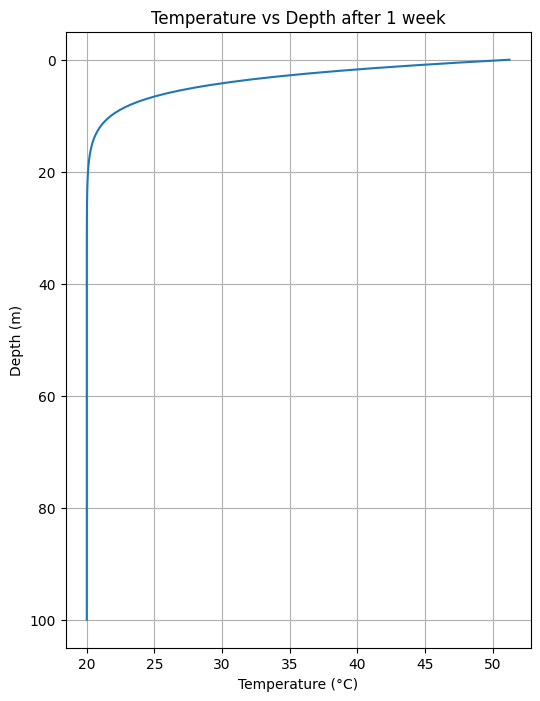

In [ ]:
# -----------------------------
# Physical and numerical setup
# -----------------------------
z = np.linspace(0, 100, 201)  # depth 0–100 m
dz = z[1] - z[0]

T0 = 293.15  # 20°C in Kelvin
T_profile = np.ones_like(z) * T0  # uniform initial temperature

dt = 60        # 1 minute in seconds
t_total = 7*24*60*60  # simulate 1 week
nt = int(t_total / dt)

Cw = 4.138e6  # J/m^3/K
Kappa_m = 1e-6  # m^2/s molecular diffusivity
Az = 1  # remove lake area from forcing for simplicity

# Shortwave radiation forcing
K_star = 200  # W/m^2 typical daily average
eta = 0.3
beta = 0.1
phi = (1-beta) * K_star * np.exp(-eta*z)  # W/m^2

# Eddy diffusivity profile
K0 = 1e-5  # minimum eddy diffusivity m^2/s
K = np.ones_like(z) * K0
K = np.maximum(K, 1e-6)

# Top boundary condition (surface heat flux → temperature gradient)
dTdz_top = 0.0
dTdz_bottom = 0.0

# -----------------------------
# Finite Difference Function
# -----------------------------
def dTdt_upwind(T, K, Kappa_m, phi, Cw, dz, dTdz_top, dTdz_bottom):
    dTdz = np.zeros_like(T)
    dTdz[1:-1] = (T[2:] - T[:-2]) / (2*dz)
    dTdz[0] = dTdz_top
    dTdz[-1] = dTdz_bottom

    Ktot = K + Kappa_m
    dKdz = np.zeros_like(K)
    dKdz[1:-1] = (Ktot[2:] - Ktot[:-2]) / (2*dz)
    dKdz[0] = dKdz[1]
    dKdz[-1] = dKdz[-2]

    d2Tdz2 = np.zeros_like(T)
    d2Tdz2[1:-1] = (T[2:] - 2*T[1:-1] + T[:-2]) / dz**2
    d2Tdz2[0] = d2Tdz2[1]
    d2Tdz2[-1] = d2Tdz2[-2]

    term1 = Ktot * d2Tdz2 + dKdz * dTdz

    # Forcing term (convert W/m^2 → K/s)
    dphi_dz = np.zeros_like(phi)
    dphi_dz[1:] = (phi[1:] - phi[:-1]) / dz
    dphi_dz[0] = (phi[1] - phi[0]) / dz
    #term2 = dphi_dz / Cw
    term2 = phi / Cw  # K/s
    return term1 + term2

# -----------------------------
# Time integration
# -----------------------------
for n in range(nt):
    dTdt = dTdt_upwind(T_profile, K, Kappa_m, phi, Cw, dz, dTdz_top, dTdz_bottom)
    T_profile += dTdt * dt

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(6,8))
plt.plot(T_profile-273.15, z)
plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title("Temperature vs Depth after 1 week")
plt.grid(True)
plt.show()


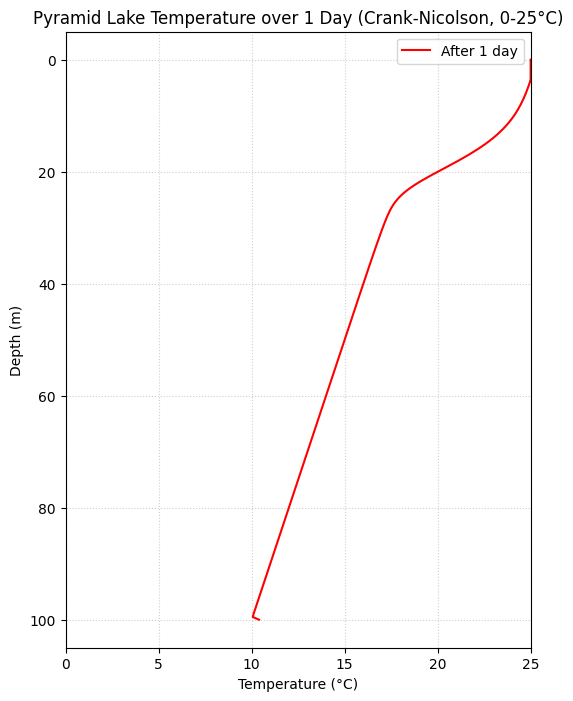

In [ ]:
#Our Crank Nicholson Temperature vs Depth Simulation
# PARAMETERS
T_surface = 20.0  # Initial surface temperature in °C
z = np.linspace(0, 100, 201)  # Create a depth grid from 0 to 100 meters with 201 points
dz = z[1] - z[0] # Calculate the uniform spatial step (depth increment)

dt = 10*60  # Set the time step to 10 minutes in seconds
total_time = 24*60*60  # Set the total simulation time to 1 day in seconds
num_steps = int(total_time / dt) # Calculate the total number of time steps

Az = 430000  # Lake surface area (m^2) - not explicitly used in this 1D model
Kappa_m = 0.01 / (24*3600)  # Molecular diffusivity (m^2/s), converted from m^2/day
Cw = 4.138e6  # Volumetric heat capacity of water (J/m^3/°C)

# Radiation & heat source parameters
beta = 0.10 # Fraction of shortwave radiation absorbed at the surface
eta = 0.3 # Light extinction coefficient (m^-1)
K_star = 600 # Net shortwave radiation at the surface (W/m^2)
phi = (1-beta)*K_star*np.exp(-eta*z)  # Calculate the shortwave radiation flux as a function of depth (W/m^2)
volumetric_heat_source = -np.gradient(phi, dz) / Cw  # Calculate the volumetric heat source due to shortwave absorption (°C/s)

# Eddy diffusion parameters
k = 0.4 # Von Karman constant
U2 = 5 # Wind speed (m/s)
P0 = 1.0 # Empirical constant
w_star = 1.2e-3 * U2 # Shear velocity (m/s)
latitude_deg = 40 # Latitude in degrees
phi_rad = np.radians(latitude_deg) # Convert latitude to radians
k_star = 6.6 * (np.sin(phi_rad))**0.5 * U2**(-1.84) # Empirical constant for eddy diffusivity

# Initial temperature profile (linear from surface)
T = T_surface - 0.1*z  # Initialize temperature profile with a small linear gradient (°C)
T_history = np.zeros((num_steps+1, len(z))) # Initialize array to store temperature profiles at each time step
T_history[0,:] = T.copy() # Store the initial temperature profile

# Eddy diffusivity calculation (simplified, using the initial T profile for stability)
g = 9.80665 # Acceleration due to gravity (m/s^2)
rho = (1 - 1.9549e-5 * np.abs(T - 4)**1.68) * 1e3 # Calculate water density as a function of temperature (kg/m^3)
drho_dz = np.gradient(rho, z) # Calculate the vertical gradient of density
N2 = np.maximum(-g/rho * drho_dz, 0) # Calculate the Brunt-Vaisala frequency squared (N^2) for stability
# Calculate the gradient Richardson number (Ri)
Ri = (-1.0 + np.sqrt(1 + (40*N2*k**2*z**2)/(w_star**2 * np.exp(-2*k*z)))) / 20
prefactor = (k*w_star*z)/P0 # Calculate a prefactor for eddy diffusivity
decay = np.exp(-k_star*z) # Calculate an exponential decay term
stab = 1.0 + 37*Ri**2 # Calculate a stability term based on Ri
K = prefactor*decay/stab # Calculate the eddy diffusivity profile (m^2/s)
# The eddy diffusivity K is calculated once based on the initial temperature profile

# Crank-Nicolson method coefficients setup
N = len(z) # Number of grid points
alpha = dt / (2*dz**2) # Define the Crank-Nicolson parameter alpha

# Neumann top and bottom flux (simplified, constant values for this example)
f_top = 0.0001  # Approximate surface temperature flux (°C/s)
f_bottom = 0.0  # Zero temperature flux at the bottom boundary (°C/s)

# TIME LOOP
for n in range(num_steps): # Iterate over each time step
    D = Kappa_m + K # Total diffusivity is the sum of molecular and eddy diffusivity
    D_ip1_2 = (D[1:] + D[:-1])/2 # Calculate diffusivity at cell interfaces (i+1/2)

    # Initialize arrays for the tridiagonal matrix coefficients (a, b, c) and RHS vector (d)
    a = np.zeros(N) # Sub-diagonal
    b = np.zeros(N) # Main diagonal
    c = np.zeros(N) # Super-diagonal
    d = np.zeros(N) # Right-hand side vector

    # Populate coefficients for internal nodes (1 to N-2)
    for i in range(1,N-1):
        a[i] = -alpha*D_ip1_2[i-1] # Coefficient for T_{i-1}^{n+1}
        b[i] = 1 + alpha*(D_ip1_2[i-1]+D_ip1_2[i]) # Coefficient for T_{i}^{n+1}
        c[i] = -alpha*D_ip1_2[i] # Coefficient for T_{i+1}^{n+1}
        # Right-hand side for internal nodes (uses T at time n)
        d[i] = alpha*D_ip1_2[i-1]*T[i-1] + (1 - alpha*(D_ip1_2[i-1]+D_ip1_2[i]))*T[i] + alpha*D_ip1_2[i]*T[i+1] + dt*volumetric_heat_source[i]

    # Top Neumann boundary condition (i=0)
    b[0] = 1 + 2*alpha*D_ip1_2[0] # Main diagonal coefficient for T_0^{n+1}
    c[0] = -2*alpha*D_ip1_2[0] # Super-diagonal coefficient for T_1^{n+1}
    # Right-hand side for top boundary (includes flux term f_top)
    d[0] = T[0] + 2*alpha*D_ip1_2[0]*T[1] + 2*alpha*dz*f_top + dt*volumetric_heat_source[0]

    # Bottom Neumann boundary condition (i=N-1)
    a[-1] = -2*alpha*D_ip1_2[-1] # Sub-diagonal coefficient for T_{N-2}^{n+1}
    b[-1] = 1 + 2*alpha*D_ip1_2[-1] # Main diagonal coefficient for T_{N-1}^{n+1}
    # Right-hand side for bottom boundary (f_bottom is 0, so no explicit flux term here)
    d[-1] = T[-1] + 2*alpha*D_ip1_2[-1]*T[-2] + dt*volumetric_heat_source[-1]

    # Thomas algorithm for solving the tridiagonal system Ax = d
    c_star = np.zeros(N) # Modified super-diagonal
    d_star = np.zeros(N) # Modified right-hand side
    c_star[0] = c[0]/b[0] # Forward elimination for first row
    d_star[0] = d[0]/b[0] # Forward elimination for first row
    for i in range(1,N): # Forward elimination for remaining rows
        temp = b[i] - a[i]*c_star[i-1] # Calculate temporary denominator
        c_star[i] = c[i]/temp if i<N-1 else 0 # Calculate modified super-diagonal
        d_star[i] = (d[i]-a[i]*d_star[i-1])/temp # Calculate modified right-hand side

    T_new = np.zeros(N) # Array to store the new temperature profile
    T_new[-1] = d_star[-1] # Back substitution for the last element
    for i in range(N-2,-1,-1): # Back substitution for remaining elements
        T_new[i] = d_star[i] - c_star[i]*T_new[i+1]

    T_new = np.clip(T_new, 0, 25)  # Restrict temperatures to a realistic range (0-25°C)
    T = T_new.copy() # Update the temperature profile for the next time step
    T_history[n+1,:] = T # Store the updated temperature profile

# PLOT
plt.figure(figsize=(6,8)) # Create a new figure with specified size
# plt.plot(T_history[0,:], z, label='Initial') # Plot the initial temperature profile (commented out as requested)
plt.plot(T_history[-1,:], z, label='After 1 day', color='red') # Plot the final temperature profile after 1 day
plt.gca().invert_yaxis() # Invert the y-axis so depth increases downwards
plt.xlabel('Temperature (°C)') # Set x-axis label
plt.ylabel('Depth (m)') # Set y-axis label
plt.title('Pyramid Lake Temperature over 1 Day (Crank-Nicolson, 0-25°C)') # Set plot title
plt.grid(True, linestyle=':', alpha=0.6) # Add a grid to the plot
plt.legend() # Display the legend
plt.xlim(0, 25) # Set x-axis limits to 0-25 degrees Celsius
plt.show() # Display the plot

In [ ]:
#installing prebuilt solver packages
!pip install py-pde
import pde
print(pde.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.9/332.9 kB 23.7 MB/s eta 0:00:00
0.47.2


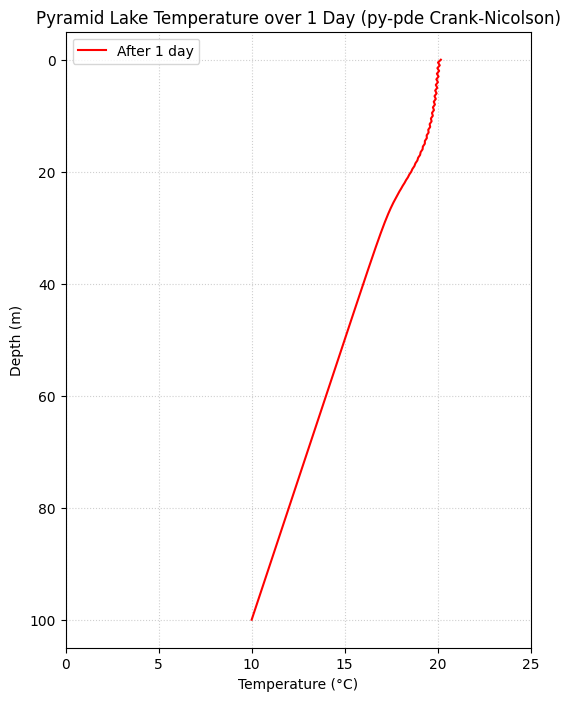

In [ ]:
# Crank Nicholson Temperature vs Depth Simulation using a Prebuilt Solver

from pde import ScalarField, CartesianGrid, PDE, CrankNicolsonSolver, MemoryStorage # Import necessary classes from py-pde library

# PARAMETERS
z_coords = np.linspace(0, 100, 201)  # Create a depth grid from 0 to 100 meters with 201 points
dz = z_coords[1]-z_coords[0] # Calculate the uniform spatial step (depth increment)
T_surface = 20.0  # Initial surface temperature in °C

# Initial temperature profile (linear)
T0 = T_surface - 0.1*z_coords  # Initialize temperature profile with a small linear gradient (°C)

# Diffusivity parameters
Kappa_m = 0.01 / (24*3600)  # Molecular diffusivity (m²/s), converted from m^2/day
k = 0.4 # Von Karman constant
U2 = 5 # Wind speed (m/s)
P0 = 1.0 # Empirical constant
w_star = 1.2e-3 * U2 # Shear velocity (m/s)
latitude_deg = 40 # Latitude in degrees
phi_rad = np.radians(latitude_deg) # Convert latitude to radians
k_star = 6.6 * (np.sin(phi_rad))**0.5 * U2**(-1.84) # Empirical constant for eddy diffusivity
g = 9.80665 # Acceleration due to gravity (m/s^2)

#Compute the eddy diffusivity
rho = (1 - 1.9549e-5 * np.abs(T0 - 4)**1.68) * 1e3 # Calculate water density as a function of temperature (kg/m^3)
drho_dz = np.gradient(rho, z_coords) # Calculate the vertical gradient of density
N2 = np.maximum(-g/rho * drho_dz, 0) # Calculate the Brunt-Vaisala frequency squared (N^2) for stability

# To avoid NaN/inf for Ri where z=0, as in previous robust code.
Ri = np.zeros_like(z_coords) # Initialize Ri as zero array
valid_z_indices = z_coords > 0 # Identify indices where depth is greater than zero
if np.any(valid_z_indices): # Check if there are any valid non-zero depths
    valid_z = z_coords[valid_z_indices] # Get valid non-zero depths
    numerator = (40 * N2[valid_z_indices] * k**2 * valid_z**2) # Calculate numerator for Ri
    denominator = (w_star**2 * np.exp(-2*k*valid_z)) # Calculate denominator for Ri
    # Handle cases where denominator might be very small or zero for numerical stability
    denominator[denominator < 1e-10] = 1e-10 # Set a small threshold for denominator to prevent division by zero
    Ri[valid_z_indices] = (-1.0 + np.sqrt(1 + numerator / denominator)) / 20 # Calculate Richardson number for valid depths

prefactor = (k*w_star*z_coords)/P0 # Calculate a prefactor for eddy diffusivity
decay = np.exp(-k_star*z_coords) # Calculate an exponential decay term
stab = 1.0 + 37*Ri**2 # Calculate a stability term based on Ri
K = prefactor*decay/stab # Calculate the eddy diffusivity profile (m^2/s)
# Ensure K[0] is not zero for stability/division in f_top or diffusivity.
K[0] = max(K[1]*0.2, 1e-8) # Set a minimum positive value for surface eddy diffusivity
D_total = Kappa_m + K # Total diffusivity is the sum of molecular and eddy diffusivity

# Volumetric heat source (°C/s)
beta = 0.1 # Fraction of shortwave radiation absorbed at the surface
eta = 0.3 # Light extinction coefficient (m^-1)
K_star = 600 # Net shortwave radiation at the surface (W/m^2)
phi = (1-beta)*K_star*np.exp(-eta*z_coords) # Calculate the shortwave radiation flux as a function of depth (W/m^2)
Cw = 4.138e6 # Volumetric heat capacity of water (J/m^3/°C)
volumetric_heat_source = -np.gradient(phi, dz)/Cw # Calculate the volumetric heat source due to shortwave absorption (°C/s)


# Neumann top and bottom flux (simplified, constant values for this example)
f_top = 0.0001  # Approximate surface temperature gradient (°C/m)
f_bottom = 0.0  # Zero temperature gradient at the bottom boundary (°C/m)

# PY-PDE GRID & FIELD
# Use CartesianGrid to specify coordinates directly.
# The grid takes bounds for each dimension and number of points.
# For 1D, bounds are `[(min_z, max_z)]`.
grid = CartesianGrid([(0, 100)], [len(z_coords)], periodic=False) # Create a Cartesian grid for the simulation domain

# Create ScalarField for initial temperature
field = ScalarField(grid, T0) # Create a ScalarField object representing the initial temperature distribution on the grid

# Create ScalarField for D_total and volumetric_heat_source to be used as constants
D_field = ScalarField(grid, D_total) # Create a ScalarField for the total diffusivity
source_field = ScalarField(grid, volumetric_heat_source) # Create a ScalarField for the volumetric heat source

# Define a 1D diffusion PDE with variable diffusivity + source term using string expression
# Equation: dT/dt = d/dz (D dT/dz) + S
# In py-pde: dT/dt = divergence(D_val * gradient(u)) + source_val
pde_eq = PDE( # Define the Partial Differential Equation
    {'u': 'divergence(D_val * gradient(u)) + source_val'}, # Define the equation for variable 'u' (temperature)
    consts={'D_val': D_field, 'source_val': source_field}, # Pass constant fields for diffusivity and source term
    bc={'u': {'lower': {'derivative': f_top}, 'upper': {'derivative': f_bottom}}} # Define Neumann boundary conditions for 'u'
)
# SOLVE USING PREBUILT CRANK-NICOLSON
# Solve for 1 day
t_end = 24*3600 # Set the total simulation time to 1 day in seconds
dt_solver = 5 # Set the time step for the solver to 5 seconds

# We can use MemoryStorage to track the solution at different times.
storage = MemoryStorage() # Create a MemoryStorage object to store simulation results

# solve returns the final state. Using tracker allows saving intermediate states.
result = pde_eq.solve(field, t_range=t_end, dt=dt_solver, solver=CrankNicolsonSolver, tracker=storage.tracker(), backend='numpy') # Solve the PDE using Crank-Nicolson solver

#PLOT FINAL PROFILE
plt.figure(figsize=(6,8)) # Create a new figure with specified size
plt.plot(result.data, z_coords, color='red', label='After 1 day') # Plot the final temperature profile from py-pde
plt.gca().invert_yaxis() # Invert the y-axis so depth increases downwards
plt.xlabel('Temperature (°C)') # Set x-axis label
plt.ylabel('Depth (m)') # Set y-axis label
plt.title('Pyramid Lake Temperature over 1 Day (py-pde Crank-Nicolson)') # Set plot title
plt.xlim(0,25) # Set x-axis limits to 0-25 degrees Celsius
plt.grid(True, linestyle=':', alpha=0.6) # Add a grid to the plot
plt.legend() # Display the legend
plt.show() # Display the plot

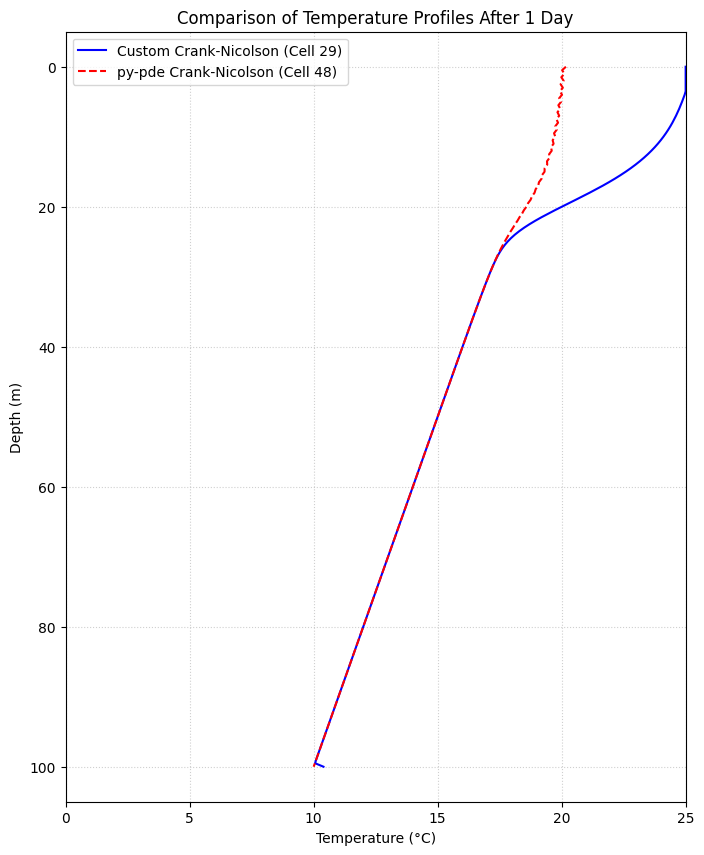

In [ ]:
#Comparing the prebuilt solver vs our own graph


final_T_custom = T_history[-1, :] # Get the final temperature profile from the custom Crank-Nicolson solution
depth_z = z # Get the depth coordinates from the global 'z' variable

# Parameters
T_surface = 20.0  # Initial surface temperature in °C
T0_pde = T_surface - 0.1*z_coords # Initialize temperature profile for py-pde with a small linear gradient (°C)

Kappa_m = 0.01 / (24*3600)  # Molecular diffusivity (m²/s), converted from m^2/day
k = 0.4 # Von Karman constant
U2 = 5 # Wind speed (m/s)
P0 = 1.0 # Empirical constant
w_star = 1.2e-3 * U2 # Shear velocity (m/s)
latitude_deg = 40 # Latitude in degrees
phi_rad = np.radians(latitude_deg) # Convert latitude to radians
k_star = 6.6 * (np.sin(phi_rad))**0.5 * U2**(-1.84) # Empirical constant for eddy diffusivity
g = 9.80665 # Acceleration due to gravity (m/s^2)

rho = (1 - 1.9549e-5 * np.abs(T0_pde - 4)**1.68) * 1e3 # Calculate water density as a function of temperature (kg/m^3)
drho_dz = np.gradient(rho, z_coords) # Calculate the vertical gradient of density
N2 = np.maximum(-g/rho * drho_dz, 0) # Calculate the Brunt-Vaisala frequency squared (N^2) for stability

Ri = np.zeros_like(z_coords) # Initialize Ri as zero array
valid_z_indices = z_coords > 0 # Identify indices where depth is greater than zero
if np.any(valid_z_indices): # Check if there are any valid non-zero depths
    valid_z = z_coords[valid_z_indices] # Get valid non-zero depths
    numerator = (40 * N2[valid_z_indices] * k**2 * valid_z**2) # Calculate numerator for Ri
    denominator = (w_star**2 * np.exp(-2*k*valid_z)) # Calculate denominator for Ri
    denominator[denominator < 1e-10] = 1e-10 # Set a small threshold for denominator to prevent division by zero
    Ri[valid_z_indices] = (-1.0 + np.sqrt(1 + numerator / denominator)) / 20 # Calculate Richardson number for valid depths

prefactor = (k*w_star*z_coords)/P0 # Calculate a prefactor for eddy diffusivity
decay = np.exp(-k_star*z_coords) # Calculate an exponential decay term
stab = 1.0 + 37*Ri**2 # Calculate a stability term based on Ri
K = prefactor*decay/stab # Calculate the eddy diffusivity profile (m^2/s)
K[0] = max(K[1]*0.2, 1e-8) # Set a minimum positive value for surface eddy diffusivity
D_total = Kappa_m + K # Total diffusivity is the sum of molecular and eddy diffusivity


beta = 0.1 # Fraction of shortwave radiation absorbed at the surface
eta = 0.3 # Light extinction coefficient (m^-1)
K_star = 600 # Net shortwave radiation at the surface (W/m^2)
phi = (1-beta)*K_star*np.exp(-eta*z_coords) # Calculate the shortwave radiation flux as a function of depth (W/m^2)
Cw = 4.138e6 # Volumetric heat capacity of water (J/m^3/°C)
volumetric_heat_source = -np.gradient(phi, dz)/Cw # Calculate the volumetric heat source due to shortwave absorption (°C/s)

f_top = 0.0001 # Approximate surface temperature gradient (°C/m)
f_bottom = 0.0 # Zero temperature gradient at the bottom boundary (°C/m)

grid = CartesianGrid([(0, 100)], [len(z_coords)], periodic=False) # Create a Cartesian grid for the simulation domain
field_pde = ScalarField(grid, T0_pde) # Create a ScalarField object representing the initial temperature distribution on the grid for py-pde
D_field = ScalarField(grid, D_total) # Create a ScalarField for the total diffusivity
source_field = ScalarField(grid, volumetric_heat_source) # Create a ScalarField for the volumetric heat source

pde_eq_comparison = PDE( # Define the Partial Differential Equation for comparison
    {'u': 'divergence(D_val * gradient(u)) + source_val'}, # Define the equation for variable 'u' (temperature)
    consts={'D_val': D_field, 'source_val': source_field},
    bc={'u': {'lower': {'derivative': f_top}, 'upper': {'derivative': f_bottom}}} # Define Neumann boundary conditions for 'u'
)


t_end = 24*3600 # Set the total simulation time to 1 day in seconds
dt_solver = 5 # Set the time step for the solver to 5 seconds
storage = MemoryStorage() # Create a MemoryStorage object to store simulation results

result_pde_comparison = pde_eq_comparison.solve(field_pde, t_range=t_end, dt=dt_solver, solver=CrankNicolsonSolver, tracker=storage.tracker(), backend='numpy') # Solve the PDE using Crank-Nicolson solver
final_T_py_pde = result_pde_comparison.data # Get the final temperature profile from the py-pde solution

#Plotting Comparison
plt.figure(figsize=(8, 10)) # Create a new figure with specified size
plt.plot(final_T_custom, depth_z, label='Custom Crank-Nicolson (Cell 29)', color='blue') # Plot the custom solution
plt.plot(final_T_py_pde, depth_z, label='py-pde Crank-Nicolson (Cell 48)', color='red', linestyle='--') # Plot the py-pde solution

plt.gca().invert_yaxis() # Invert the y-axis so depth increases downwards
plt.xlabel('Temperature (°C)') # Set x-axis label
plt.ylabel('Depth (m)') # Set y-axis label
plt.title('Comparison of Temperature Profiles After 1 Day') # Set plot title
plt.grid(True, linestyle=':', alpha=0.6) # Add a grid to the plot
plt.legend() # Display the legend
plt.xlim(0, 25) # Set x-axis limits to 0-25 degrees Celsius
plt.show() # Display the plot

**Original Limnological Graph ** 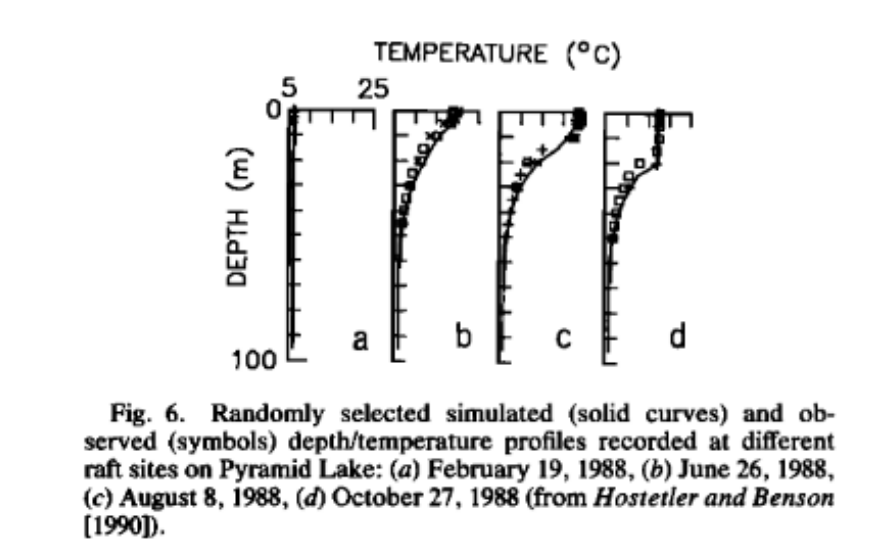

In [ ]:
#Stability and Accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Error Metrics

# Absolute Error
absolute_error = np.abs(final_T_custom - final_T_py_pde)

# Relative Error (handle potential division by zero)
relative_error = np.zeros_like(final_T_py_pde, dtype=float)
non_zero_indices = final_T_py_pde != 0
relative_error[non_zero_indices] = absolute_error[non_zero_indices] / final_T_py_pde[non_zero_indices]

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(final_T_custom, final_T_py_pde))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(final_T_custom, final_T_py_pde)

# Mean Absolute Percentage Error (MAPE) - handle division by zero for percentage
mape = np.mean(np.abs((final_T_custom[non_zero_indices] - final_T_py_pde[non_zero_indices]) / final_T_py_pde[non_zero_indices])) * 100

print(f"--- Error Metrics ---")
print(f"RMSE: {rmse:.4f} °C")
print(f"MAE: {mae:.4f} °C")
print(f"MAPE (excluding zero py-pde values): {mape:.2f} %")

--- Error Metrics ---
RMSE: 1.8659 °C
MAE: 0.8423 °C
MAPE (excluding zero py-pde values): 4.30 %

Note: MAPE might be skewed if many py-pde values are near zero.


**Results**

We present simulations of 3 limological graphs using Crank Nicholson and Finite Difference Method

**1. Finite Difference Method**
For the Finite Difference Method, a simulation was run for temperature versus depth over a course of a week for lake Pyramid. This was based on the 1D Eddy Diffusion Model. Since this is an explicit method, it was unstable and the temperature values were inacurrate. When compared to the model in the paper based on observations for Lake Pyramid's temperature, the shape of the temperature depth profile was similar, but the temperatures in the observational data was about 25 degrees Celsius cooler than the FDM figure. When the time steps for this method is changed, the graph explodes even more due to its explicit nature and it loses its thermocline shape.

**2. Our version using the Crank Nicholson Method**

In our model using the Crank Nicholson numerical method we simuated temperature versus depth over the course of one day. The inital temperature was 20 degrees Celcius, the surface temperature reached 25 degrees Celsius. Indicating that the forcing conditions were strong enough to warm the upper layer considerably. Below the surface, the temperature rapidly decrease for around 40 meters. This temperature decrease marks the formation of the thermocline. Unlike the orginal simulation and data observed in the 1980s , our graph does not reach a steady state before it reaches the bottom of the lake at 100 meters.

**3. Crank Nichoslon done using a pre-built solver**

Unlike our simulation the pre-built solver begins at the initial temperature of 20 degrees celcius. Experincing slight turbuation until around 25 meters where there is a dramatic decrease in temperature. Like our simulation the prebuilt solver begins reaching the thermocline, but does not before getting to the bottom of the lake.

**Stability and Acccuracy**

**Summary**

Our Crank-Nicholson model, even with its simplified 1-day run and temperature clipping, effectively illustrates fundamental limnological principles of heat transfer and thermal stratification in a lake. It successfully shows how forcing conditions affect surface temperatures, formation of a thermocline, limited deep water heating, and the influence of volumetric heating and eddy diffusivity.

The Finite Difference Method model portrays how sensitive models can be to certain timesteps when there are explicit and unstable. However, by adjusting some of the parameters, we were able to simulate the temperature profile of a shallow lake within a one week time frame. This graph was able to illustrate some of the limnological principles of heat transfer and thermal stratification. While not being completely successful, it was able to show how forcing conditions can affect temperatures at depth and the formation of a thermocline in a lake. This model can be improved by using an implicit method like backward Euler or Crank Nicholson instead of an unstable explicit method. This will allow the graph to more accurately represent how the tmperature changes at depth in a lake.

Our model was overly simplified compared to the one from the paper. This could be improved by incorporating more of the equations and less estimations for variables. Also, having access to more observational data for Lake Pyramid would improve some of these graphs and figures.

### References

Hostetler, S. W., and P. J. Bartlein (1990), Simulation of lake evaporation with application to modeling lake level variations of Harney-Malheur Lake, Oregon, Water Resour. Res., 26(10), 2603–2612, doi:10.1029/WR026i010p02603.


International Lake Environment Committee (ILEC) (2025), Pyramid Lake, World Lake Database, available at https://wldb.ilec.or.jp/Display/html/3424


### Video Link
(19 minutes and 46 seconds)

https://mediaspace.gatech.edu/media/Grant_Gabby_ESM/1_res7ijbh